# Monte Carlo Pricer

This notebook validates a Geometric Brownian Motion (GBM) Monte Carlo pricer against the Black–Scholes closed form, examining convergence for Euler–Maruyama vs Milstein methods to numerically solve the Stochastic Differential Equation (SDE), and demonstrates variance reduction through antithetic sampling for efficiency.


In [1]:
# Import necessary libraries and functions
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


## Monte Carlo helpers

We use risk‑neutral GBM dynamics with drift, compute discounted payoffs, and return mean price, standard error, and 95% confidence intervals to quantify estimator uncertainty.


In [2]:
def simulate_gbm_paths(S0, r, sigma, T, N, M, scheme="euler", antithetic=False, seed=0):
    """
    This function generates Geometric Brownian Motion (GBM) paths.

    Args:
        S0 (float):             The starting point of the paths.
        r (float):              The 'percentage drift' constant of the GBM (risk-free interest rate).
        sigma (float):          The 'percentage volatility' constant of the GBM.
        T (float):              The expiry time of the paths -- the maturity time of the asset.
        N (int):                The number of time steps to be simulated.
        M (int):                The number of paths to be simulated.
        scheme (str, optional): The scheme used to solve the SDE. Default is "euler". Alternative is "milstein".
        method (str, optional): The method used to generate the path ensemble. Default is "standard". Alternative is "antithetic".
        seed (int, optional):             The seed of the random number generator.

    Returns:
        paths:                  The GBM paths generated by the algorithm.
    
    Raises:
        ValueError:             Raises an Error if an invalid scheme is passed to the function.
    """
    rng = np.random.default_rng(seed)
    dt = T / N
    paths = np.empty((M, N+1), dtype=float)
    paths[:, 0] = S0
    for n in range(N):
        if antithetic:
            M1 = (M+1)//2
            z1 = rng.standard_normal(M1)
            z2 = -z1[:(M-M1)]
            z = np.append(z1,z2)
        else:
            z = rng.standard_normal(M)
        
        dW = np.sqrt(dt) * z
        S = paths[:, n]
        if scheme == "euler":
            paths[:, n+1] = S + r*S*dt + sigma*S*dW
        elif scheme == "milstein":
            paths[:, n+1] = S + r*S*dt + sigma*S*dW + 0.5*(sigma**2)*S*(dW**2 - dt)
        else:
            raise ValueError("'scheme' must be 'euler' or 'milstein'")
    return paths

def price_euro_mc(S0, K, r, sigma, T, N, M, scheme="euler", antithetic=False, seed=0):
    """
    This function returns the Option Price MC estimates of the European's Call and Put options.

    Args:
        S0 (float):             The starting point of the paths (current asset price).
        K (float):              The Strike price.
        r (float):              The 'percentage drift' constant of the GBM (risk-free interest rate).
        sigma (float):          The 'percentage volatility' constant of the GBM.
        T (float):              The expiry time of the paths -- the maturity time of the asset.
        N (int):                The number of time steps to be simulated.
        M (int):                The number of paths to be simulated.
        scheme (str, optional): The scheme used to solve the SDE. Default is "euler". Alternative is "milstein".
        seed (int,optional):    The seed of the random number generator.

    Returns:
        A dictionary containing:
            est_call (float):   The Option Price MC estimate of the European's call price.
            se_call (float):    The standard error of est_call.
            ci95_call (float):  The 95% CI of est_call.
            est_put (float):    The Option Price MC estimate of the European's put price.
            se_put (float):     The standard error of the est_put.
            ci95_put (float):  The 95% CI of est_put.
    
    Raises:
        ValueError:             Raises an Error if an invalid scheme is passed.
    """
    # Simulate GBM paths using MC algorithm
    paths = simulate_gbm_paths(S0, r, sigma, T, N, M, scheme=scheme, antithetic=antithetic, seed=0)
    # Get the Future Simulated Price of each path
    ST = paths[:, -1] 
    # Evaluate the payoff of call and put options
    payoff_call = np.maximum(ST - K, 0.0)
    payoff_put = np.maximum(K- ST, 0.0)
    # Discount back to the present value
    disc = np.exp(-r*T) 
    pv_call = disc * payoff_call
    pv_put = disc * payoff_put

    est_call  = pv_call.mean()
    est_put   = pv_put.mean()
    var_call  = (disc**2) * pv_call.var(ddof=1) / len(pv_call)
    var_put   = (disc**2) * pv_put.var(ddof=1) / len(pv_put)
    se_call   = np.sqrt(var_call)
    se_put    = np.sqrt(var_put)

    ci95_call = (est_call - 1.96*se_call, est_call + 1.96*se_call)
    ci95_put = (est_put - 1.96*se_put, est_put + 1.96*se_put)

    return {"price_call": est_call, "se_call": se_call, "ci95_call": ci95_call, "price_put": est_put, "se_put": se_put, "ci95_put": ci95_put}

## Black–Scholes reference

We implement the Black–Scholes–Merton closed form to benchmark Monte Carlo estimates to an analytical ground truth.


In [3]:
def BS_call_put(S0, K, r, sigma, T):
    """
    This function returns the solution of the Black-Scholes Equation for the Option Prices of the European's Call and Put options.

    Args:
        S0 (float):             The starting point of the paths (current asset price).
        K (float):              The Strike price.
        r (float):              The 'percentage drift' constant of the GBM (risk-free interest rate).
        sigma (float):          The 'percentage volatility' constant of the GBM.
        T (float):              The expiry time of the paths -- the maturity time of the asset.

    Returns:
        pv_call:                The Option Price solution of the BS equation of the European's call price.
        pv_put:                 The Option Price solution of the BS equation of the European's put price.
    """
    if T <= 0: 
        pv_call = max(S0 - K, 0.0)
        pv_put  = max(K - S0, 0.0)
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    pv_call = S0*norm.cdf(d1)- K*np.exp(-r*T)*norm.cdf(d2)
    pv_put = K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    return  pv_call, pv_put

## Parameters and analytic benchmark

We set baseline parameters and compute the Black–Scholes price to serve as the reference for bias and confidence interval checks.

In [4]:
S0, K = 102.0, 100.0
r, sigma, T = 0.02, 0.20, 1.0
bs_ref_call, bs_ref_put = BS_call_put(S0, K, r, sigma, T)
print(f"Black-Scholes call: {bs_ref_call}.\nBlack-Scholes put: {bs_ref_put}.")

Black-Scholes call: 10.113115861217295.
Black-Scholes put: 6.132983191892826.


## Sanity check: MC vs Black–Scholes

We compare Euler–Maruyama and Milstein Monte Carlo estimates to Black–Scholes with confidence intervals to verify correctness under risk‑neutral GBM.

In [5]:
N, M = 252, 200000

em = price_euro_mc(S0,K,r,sigma,T,N,M,scheme="euler",seed=0)
mi = price_euro_mc(S0,K,r,sigma,T,N,M,scheme="milstein",seed=0)

pd.DataFrame({
    "method": ["Euler-Maruyama","Milstein","Black-Scholes"],
    "price": [em["price_call"], mi["price_call"], bs_ref_call],
    "SE": [em["se_call"], mi["se_call"], np.nan],
    "CI_low": [em["ci95_call"][0], mi["ci95_call"][0], np.nan],
    "CI_high":[em["ci95_call"][1], mi["ci95_call"][1], np.nan],
})


,method,price,SE,CI_low,CI_high
0,Euler-Maruyama,10.163061,0.032239,10.099873,10.226249
1,Milstein,10.161603,0.032250,10.098393,10.224813
2,Black-Scholes,10.113116,NaN,NaN,NaN


## Discretization bias: error vs steps N

We hold paths M fixed and vary time steps N to observe discretization bias relative to Black–Scholes, which highlights Milstein’s stronger pathwise convergence for GBM.


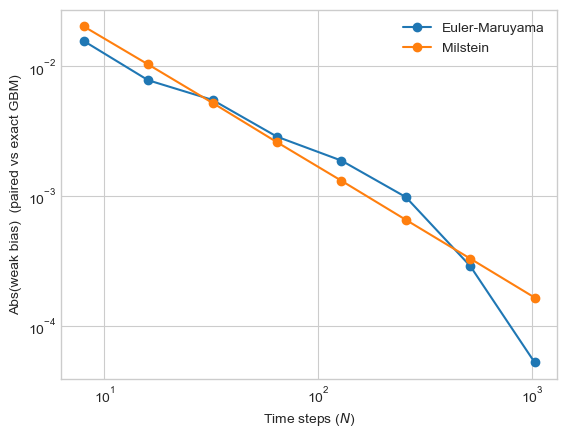

       N          scheme      bias       se
0      8  Euler-Maruyama  0.015659 0.001907
1      8        Milstein -0.020276 0.000115
2     16  Euler-Maruyama  0.007810 0.001353
3     16        Milstein -0.010331 0.000058
4     32  Euler-Maruyama  0.005507 0.000959
5     32        Milstein -0.005224 0.000029
6     64  Euler-Maruyama  0.002871 0.000682
7     64        Milstein -0.002603 0.000015
8    128  Euler-Maruyama  0.001879 0.000482
9    128        Milstein -0.001315 0.000007
10   256  Euler-Maruyama  0.000985 0.000342
11   256        Milstein -0.000658 0.000004
12   512  Euler-Maruyama  0.000290 0.000241
13   512        Milstein -0.000331 0.000002
14  1024  Euler-Maruyama -0.000053 0.000171
15  1024        Milstein -0.000166 0.000001


In [6]:
# Simulate GBM with provided Brownian increments
def GBM_dW(S0, r, sigma, T, dW, scheme="euler"):
    dt = T / dW.shape[1]
    S = np.full(dW.shape[0], S0, dtype=float)
    for n in range(dW.shape[1]):
        bm = dW[:, n]
        if scheme == "euler":
            S = S + r*S*dt + sigma*S*bm
        elif scheme == "milstein":
            S = S + r*S*dt + sigma*S*bm + 0.5*(sigma**2)*S*(bm**2 - dt)
        else:
            raise ValueError("scheme must be 'euler' or 'milstein'")
    return S

# Paired weak-bias estimator and CI for a European call
def weak_bias_paired_call(S0, K, r, sigma, T, N, M, scheme="euler", seed=0):
    rng = np.random.default_rng(seed)
    dt = T / N
    dW = np.sqrt(dt) * rng.standard_normal((M, N))
    W_T = dW.sum(axis=1)

    ST_disc  = GBM_dW(S0, r, sigma, T, dW, scheme=scheme)
    ST_exact = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*W_T)

    payoff_disc  = np.maximum(ST_disc - K, 0.0)
    payoff_exact = np.maximum(ST_exact - K, 0.0)

    disc = np.exp(-r*T)
    diff = disc*(payoff_disc - payoff_exact)  # paired differences

    bias_hat = diff.mean()
    se = diff.std(ddof=1) / np.sqrt(M)
    ci95 = (bias_hat - 1.96*se, bias_hat + 1.96*se)
    return {"bias": bias_hat, "se": se, "ci95": ci95}

# Example usage and plot
N_list = [8, 16, 32, 64, 128, 256, 512, 1024]

rows = []
for N in N_list:
    out_em = weak_bias_paired_call(S0, K, r, sigma, T, N, M=200000, scheme="euler", seed=0)
    out_mi = weak_bias_paired_call(S0, K, r, sigma, T, N, M=200000, scheme="milstein", seed=0)
    rows.append({"N":N, "scheme":"Euler-Maruyama", "bias": out_em["bias"], "se": out_em["se"]})
    rows.append({"N":N, "scheme":"Milstein", "bias": out_mi["bias"], "se": out_mi["se"]})
df_bias = pd.DataFrame(rows)

fig, ax = plt.subplots()
for scheme, g in df_bias.groupby("scheme"):
    ax.loglog(g["N"], np.abs(g["bias"]), "o-", label=scheme)
ax.set_xlabel(r"Time steps ($N$)")
ax.set_ylabel(r"Abs(weak bias)  (paired vs exact GBM)")
ax.legend()
plt.show()

print(df_bias)


## Monte Carlo error: SE vs paths M

We fix N and vary M to confirm standard error decays at rate $(1/\sqrt{M})$, as predicted by classical Monte Carlo theory for i.i.d. sampling.


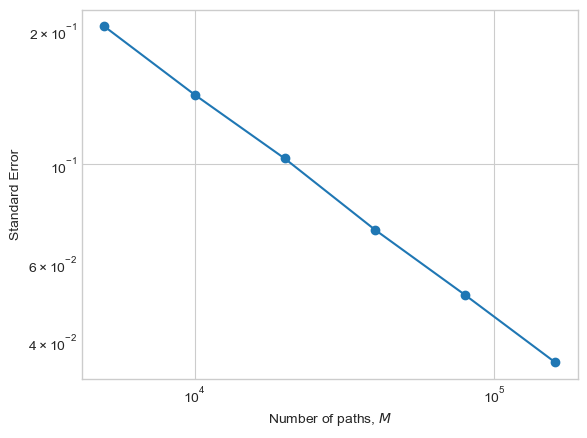

,M,price,SE
0,5000,10.340285,0.204026
1,10000,10.091217,0.143442
2,20000,10.127600,0.103107
3,40000,10.036034,0.071370
4,80000,10.126652,0.050939
5,160000,10.109319,0.035947


In [10]:
def sweep_paths(M_list, scheme, N=256, seed=0):
    rows = []
    for M_ in M_list:
        out = price_euro_mc(S0, K, r, sigma, T, N, M_, scheme=scheme, seed=seed)
        rows.append({"M": M_, "price": out["price_call"], "SE": out["se_call"]})
    return pd.DataFrame(rows)

M_list = [5000, 10000, 20000, 40000, 80000, 160000]
df_mp = sweep_paths(M_list, "euler")

fig, ax = plt.subplots()
ax.loglog(df_mp["M"], df_mp["SE"], "o-")
ax.set_xlabel(r"Number of paths, $M$")
ax.set_ylabel("Standard Error")
plt.show()

df_mp


## Variance reduction: antithetic

We demonstrate antithetic variates which typically reduces variance and speeds up computation of MC paths.


In [14]:
# Lets define a timer decorator to measure the execution time for the standard MC and antithetic methods
import time

def timer(func):
    def wrapper(*args, **kwargs):
        t_start = time.time()
        result = func(*args, **kwargs)
        t_total = time.time() - t_start
        print(t_total)
        return result, t_total
    return wrapper

@timer
def timed_price_euro_mc(S0, K, r, sigma, T, N, M, scheme="euler", antithetic=False, seed=0):
    return price_euro_mc(S0, K, r, sigma, T, N, M, scheme, antithetic, seed)

N_vr, M_vr = 500, 100000

std_mc, time_std = timed_price_euro_mc(S0, K, r, sigma, T, N_vr, M_vr, scheme="euler", seed=0)
anti, time_anti  = timed_price_euro_mc(S0, K, r, sigma, T, N_vr, M_vr, scheme="euler", antithetic=True, seed=0)

vr_anti = (std_mc["se_call"]**2) / (anti["se_call"]**2)

pd.DataFrame({
    "method": ["Plain MC","Antithetic","BS Reference"],
    "price":  [std_mc["price_call"], anti["price_call"], bs_ref_call],
    "SE":     [std_mc["se_call"], anti["se_call"], np.nan],
    "Standard MC vs Antithetic (SE^2 ratio)": [np.nan, vr_anti, np.nan],
    "Exec Time": [time_std, time_anti, np.nan]
})


2.8754727840423584
2.795849323272705


,method,price,SE,Standard MC vs Antithetic (SE^2 ratio),Exec Time
0,Plain MC,10.187395,0.045815,NaN,2.875473
1,Antithetic,10.096187,0.045446,1.016266,2.795849
2,BS Reference,10.113116,NaN,NaN,NaN


## Strong convergence: EM vs Milstein

We compare discretized terminal prices to the exact GBM solution along the same Brownian paths and plot mean absolute error vs $N$ to visualize strong‑order differences empirically.


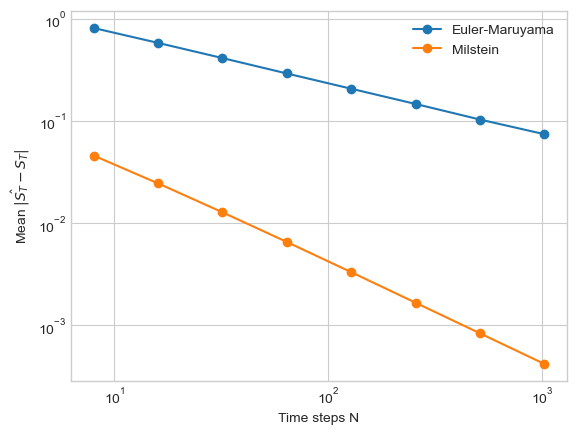

In [9]:
def strong_error_mean_abs(S0, r, sigma, T, N, M, scheme, seed=0):
    rng = np.random.default_rng(seed)
    dt = T/N
    Z = rng.standard_normal((M, N))
    dW = np.sqrt(dt) * Z

    # Exact GBM terminal solution using the same Brownian motion path
    W_T = dW.sum(axis=1)
    ST_exact = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*W_T)

    # Discretized scheme on the same dW
    S = np.full((M,), S0, float)
    for n in range(N):
        bm = dW[:, n]
        if scheme == "euler":
            S = S + r*S*dt + sigma*S*bm
        elif scheme == "milstein":
            S = S + r*S*dt + sigma*S*bm + 0.5*(sigma**2)*S*(bm**2 - dt)
        else:
            raise ValueError("'scheme' must be 'euler' or 'milstein'")
    return np.mean(np.abs(S - ST_exact))

N_grid = [8,16,32,64,128,256,512,1024]
errs_em = [strong_error_mean_abs(S0, r, sigma, T, N, 50000, "euler", seed=0) for N in N_grid]
errs_mi = [strong_error_mean_abs(S0, r, sigma, T, N, 50000, "milstein", seed=0) for N in N_grid]

fig, ax = plt.subplots()
ax.loglog(N_grid, errs_em, "o-", label=r"Euler-Maruyama")
ax.loglog(N_grid, errs_mi, "o-", label=r"Milstein")
ax.set_xlabel("Time steps N")
ax.set_ylabel(r"Mean $|\hat{S_T} - S_T|$")
ax.legend()
plt.show()


## Takeaways

- MC estimates encompass the Black–Scholes benchmark within 95% confidence intervals given sufficient paths, confirming correct simulation and discounting.  
- Discretisation pairwise bias falls as $N$ grows, and Milstein exhibits stronger pathwise convergence than Euler–Maruyama for GBM under standard conditions.  
- Standard error decays approximately as $1/\sqrt{M}$, matching classical Monte Carlo variance behavior and validating estimator uncertainty calculations.  
- Antithetic reduces variances, improving effective sample size for European options in practice.